## Modeling

In [1]:
# libraries for this project
import json
import pandas as pd
import numpy as np
from numpy import mean, std
from IPython.display import HTML
import matplotlib.pyplot as plt
from icecream import ic
#import seaborn as sns
import os.path
import sys
import gc
import feather
from icecream import ic
from sys import getsizeof
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from matplotlib import pyplot
import seaborn as sns

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

def transf_cat_num(df):

    print("preprocessing: the categorical and numerical feature now...")
    categorical_feature_names = list(df.select_dtypes(include='category').columns)
    numeric_feature_names = list(df.drop(categorical_feature_names, axis=1).columns)
    
    print("One Hot Encoder...")
    print(f'categorical features: {categorical_feature_names}')
    
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))] )
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

    # Two preprocessed steps together using the Column Transformer module
    preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_feature_names),
                  ('cat', categorical_transformer, categorical_feature_names)])
    
    return preprocessor

# Install requirements to this project
%pip install freeze
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Processing /home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work'

Note: you may need to restart the kernel to use updated packages.


In [3]:
print("Loading dataset - to modeling...")

# loading data feather format
df = pd.read_feather('../data/dataset_featureselect.ftr')

Loading dataset - to modeling...


In [4]:
df.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity       category
dtype: object

## Pipeline

In [5]:
def pipeline_project(X, model):
    # Pipeline object
    print("setting the pipeline object ...")
    print('preprocessor...')
    preprocessor = transf_cat_num(X)

    feature_selection = SelectKBest(score_func=f_regression, k = 5)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('fs', feature_selection),
                            ('scaler', StandardScaler()),
                            ('model', model)])

    print('>>> pipeline defined!')    
    return pipe

## Split-out validation dataset

In [6]:
# Regression models
def get_models():
  models['RandomForest']=RandomForestRegressor(n_estimators=5, random_state = 42, n_jobs = -1)
  models['DecisionTree']=DecisionTreeRegressor()
  #models['KNeighbors']=KNeighborsRegressor()
  models['XGBoost']=xgb.XGBRegressor(objective="reg:linear", random_state=42)
  models['CatBoost'] = cb.CatBoostRegressor(loss_function='RMSE')
  models['LinearR']= LinearRegression(n_jobs = -1) # Use all computer cores
  models['LogisticR']= LogisticRegression()
  
  return models

In [7]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

56.0666202	total: 3.9s	remaining: 2.14s
646:	learn: 59753.4289670	total: 3.9s	remaining: 2.13s
647:	learn: 59743.1072186	total: 3.9s	remaining: 2.12s
648:	learn: 59736.5415889	total: 3.91s	remaining: 2.12s
649:	learn: 59729.8961730	total: 3.91s	remaining: 2.11s
650:	learn: 59723.3728559	total: 3.92s	remaining: 2.1s
651:	learn: 59715.9776659	total: 3.92s	remaining: 2.09s
652:	learn: 59710.7994721	total: 3.93s	remaining: 2.09s
653:	learn: 59706.8503143	total: 3.93s	remaining: 2.08s
654:	learn: 59702.0389056	total: 3.94s	remaining: 2.07s
655:	learn: 59699.0326880	total: 3.94s	remaining: 2.07s
656:	learn: 59694.2334763	total: 3.94s	remaining: 2.06s
657:	learn: 59687.9243949	total: 3.95s	remaining: 2.05s
658:	learn: 59682.2095508	total: 3.95s	remaining: 2.04s
659:	learn: 59677.1410587	total: 3.96s	remaining: 2.04s
660:	learn: 59672.3800298	total: 3.96s	remaining: 2.03s
661:	learn: 59665.6355047	total: 3.96s	remaining: 2.02s
662:	learn: 59660.4474662	total: 3.96s	remaining: 2.02s
663:	learn:

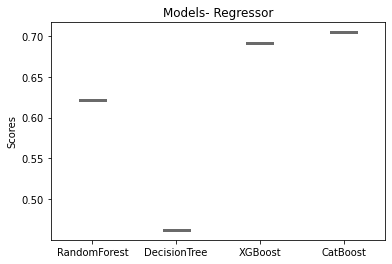

In [72]:
models = {}
models = get_models()

print(models)

# evaluate the models and store results
results = []
names = []

for name, model in models.items():

    # Alternatively X and y can be obtained directly from the dataframe attribute:
    X = df.drop('median_house_value', axis=1) # drop the column target
    y = df['median_house_value'] # target

    pipe = pipeline_project(X, model)

    ## Split-out validation dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=1)

    ## Training the model
    #print('training the model...')

    ## Fitting...
    pipe.fit(X_train, y_train)

    ## prediction
    print('prediction...')
    y_pred = pipe.predict(X_test)
    
    scores = r2_score(y_test, y_pred)
    # store the results
    results.append(scores)

    ## model names
    names.append(name)
    
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    release_memory(X)
    release_memory(y)

ic(names)
ic(results)

# plot model performance for comparison
sns.boxplot(x=names, y=results, palette="Set3", linewidth=3, width=0.3)
plt.title("Models- Regressor")
plt.ylabel("Scores") # MAE -- Mean Absolute Error
#sns.xlabel("Models")
plt.show()

[0.20002475957017063, 0.6362859123365786, 0.011944301828356856, 0.14832332501503193, 0.003421701249862069]
features selected:
the K best features selected to the model (RandomForest): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: RandomForest
latitude.......: 20.0 %
median_income.......: 63.63 %
ocean_proximity.......: 1.19 %
/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


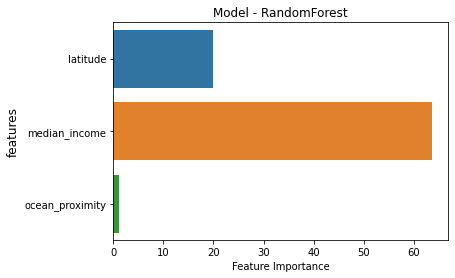

######################################################################
[0.19992168590786474, 0.6383075271980593, 0.011347615047580886, 0.14654542504603174, 0.003877746800463388]
features selected:
the K best features selected to the model (DecisionTree): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: DecisionTree
latitude.......: 19.99 %
median_income.......: 63.83 %
ocean_proximity.......: 1.13 %
/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


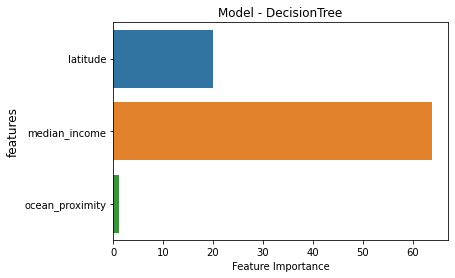

######################################################################
[0.039531298, 0.15205094, 0.04728548, 0.73226166, 0.028870597]
features selected:
the K best features selected to the model (XGBoost): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: XGBoost
latitude.......: 3.95 %
median_income.......: 15.21 %
ocean_proximity.......: 4.73 %
/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


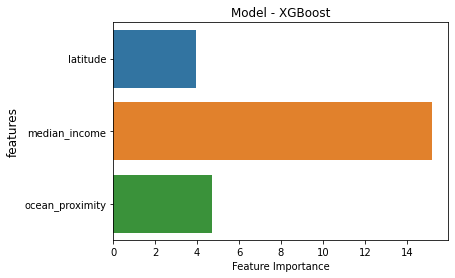

######################################################################
[32.84366998613717, 35.9768861832965, 4.933509797656067, 24.446042647191465, 1.799891385718791]
features selected:
the K best features selected to the model (CatBoost): ['latitude', 'median_income', 'ocean_proximity']
######################################################################
model: CatBoost
latitude.......: 32.84 %
median_income.......: 35.98 %
ocean_proximity.......: 4.93 %
/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


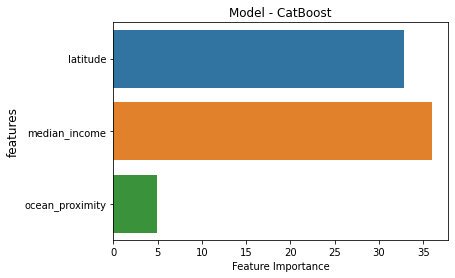

######################################################################


In [73]:
feature_names =list(X.columns)

# feature importance
for name, model in models.items():

    list_feat_importances = list(model.feature_importances_)
    print(list_feat_importances)
    
    dict_feat_importances = {}

    print('features selected:')
    mask = pipe.named_steps['fs'].get_support()

    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if(bool and (feature != 'p_esc_final')):
            new_features.append(feature)
            
    print(f'the K best features selected to the model ({name}): {new_features}')

    i=0

    print('######################################################################')
    print(f'model: {name}')

    # list of feature importances
    for ilist in new_features:

        if(name=='CatBoost'):
            dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1
        else:
            dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1

    x_axis = list(dict_feat_importances.values())
    y_axis = list(dict_feat_importances.keys())

    sns.barplot(x_axis, y_axis)
    
    plt.ylabel('features', fontsize=12)
    plt.xlabel('Feature Importance')
    plt.title(f"Model - {name}")
    plt.savefig(f'figures/feature_importance_model_{name}.png')
    plt.savefig(f'figures/feature_importance_model_{name}.pdf')
    # Show graphic
    plt.show()


    print('######################################################################')
